## DistilBERT evaluation

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import joblib as jbl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertPreTrainedModel, DistilBertConfig
import warnings
warnings.filterwarnings(category=FutureWarning, action="ignore")
warnings.filterwarnings(category=UserWarning, action="ignore")

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
df = jbl.load("preprocessed_df.pkl")
label_names = df.columns[3:-1]
y = df[label_names].to_numpy()
x = df["clean_text"]
x = [" ".join(sent) for sent in x]
print(label_names)
print(x[0])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=255)

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'water', 'food', 'shelter', 'clothing', 'money', 'missing_people',
       'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')
weather update cold front cuba could pas haiti


In [3]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(x_train, truncation=True, padding=True, max_length=50)
test_encodings = tokenizer(x_test, truncation=True, padding=True, max_length=50)

### Small dataset class and Configured Distilled BERT Transformer model

In [ ]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)
    
class BertClassifier(DistilBertPreTrainedModel):
    def __init__(self, config, hidden_dim=256):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(config.hidden_size, hidden_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_dim, config.num_labels)
        self.sigmoid = nn.Sigmoid()  #
        self.loss_fct = nn.BCELoss()
        
        self.post_init()  # pretrained weights

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        #pooled_output = outputs.last_hidden_state[:, 0]
        last_hidden_state = outputs.last_hidden_state
        #mean pooling
        pooled_output = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
        x = self.dropout(pooled_output)
        x = self.dense(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        output = self.sigmoid(x)
        
        loss = None
        if labels is not None:
            loss = self.loss_fct(output, labels)
            
        return {"loss": loss, "preds": output}

In [5]:
train_dataset = TokenizedDataset(train_encodings, y_train)
test_dataset = TokenizedDataset(test_encodings, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
num_labels = len(label_names)
config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
model = BertClassifier.from_pretrained("distilbert-base-uncased", config=config)
model.to("cuda")

Some weights of BertClassifier were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dense.bias', 'dense.weight', 'out.bias', 'out.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [7]:
EPOCHS = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10):
    history = {"loss": [], "val_loss": [], "auc": [], "val_auc": []}
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_preds, train_labels = [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            with torch.no_grad():
                preds = outputs['preds']
                train_preds.append(preds.cpu().numpy())
                train_labels.append(labels.cpu().numpy())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        history["loss"].append(avg_train_loss)

        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
        preds_bin = (train_preds > 0.5).astype(int)
        auc_train = roc_auc_score(train_labels, preds_bin, average='macro')
        history['auc'].append(auc_train)

        model.eval()
        val_loss = 0
        
        test_preds, test_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs['loss']
                val_loss += loss.item()

                preds = outputs['preds']
                test_preds.append(preds.cpu().numpy())
                test_labels.append(labels.cpu().numpy())

        test_preds = np.vstack(test_preds)
        test_labels = np.vstack(test_labels)
        avg_test_loss = val_loss / len(val_loader)
        preds_bin = (test_preds > 0.5).astype(int)
        auc_test = roc_auc_score(test_labels, preds_bin, average='macro')
        history["val_loss"].append(avg_test_loss)
        history['val_auc'].append(auc_test)

        print(f"Train loss: {avg_train_loss:.4f} | Train AUC: {auc_train:.4f} - Val loss: {avg_test_loss:.4f} | Val AUC: {auc_test:.4f}")
    return history

history = train_model(model, train_loader, test_loader, optimizer=optimizer, device="cuda", num_epochs=EPOCHS)

Epoch 1: 100%|██████████| 328/328 [01:05<00:00,  5.00it/s]


Train loss: 0.3467 | Train AUC: 0.5014 - Val loss: 0.2108 | Val AUC: 0.5109


Epoch 2: 100%|██████████| 328/328 [01:04<00:00,  5.06it/s]


Train loss: 0.1949 | Train AUC: 0.5230 - Val loss: 0.1752 | Val AUC: 0.5373


Epoch 3: 100%|██████████| 328/328 [01:04<00:00,  5.06it/s]


Train loss: 0.1692 | Train AUC: 0.5547 - Val loss: 0.1624 | Val AUC: 0.5736


Epoch 4: 100%|██████████| 328/328 [01:04<00:00,  5.05it/s]


Train loss: 0.1540 | Train AUC: 0.5782 - Val loss: 0.1558 | Val AUC: 0.5876


Epoch 5: 100%|██████████| 328/328 [01:04<00:00,  5.05it/s]


Train loss: 0.1425 | Train AUC: 0.5941 - Val loss: 0.1539 | Val AUC: 0.5951


Epoch 6: 100%|██████████| 328/328 [01:06<00:00,  4.92it/s]


Train loss: 0.1319 | Train AUC: 0.6076 - Val loss: 0.1522 | Val AUC: 0.6031


Epoch 7: 100%|██████████| 328/328 [01:06<00:00,  4.94it/s]


Train loss: 0.1224 | Train AUC: 0.6224 - Val loss: 0.1543 | Val AUC: 0.6019


Epoch 8: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Train loss: 0.1140 | Train AUC: 0.6346 - Val loss: 0.1615 | Val AUC: 0.6103


Epoch 9: 100%|██████████| 328/328 [01:07<00:00,  4.89it/s]


Train loss: 0.1069 | Train AUC: 0.6464 - Val loss: 0.1621 | Val AUC: 0.6133


Epoch 10: 100%|██████████| 328/328 [01:06<00:00,  4.91it/s]


Train loss: 0.0999 | Train AUC: 0.6573 - Val loss: 0.1667 | Val AUC: 0.6228


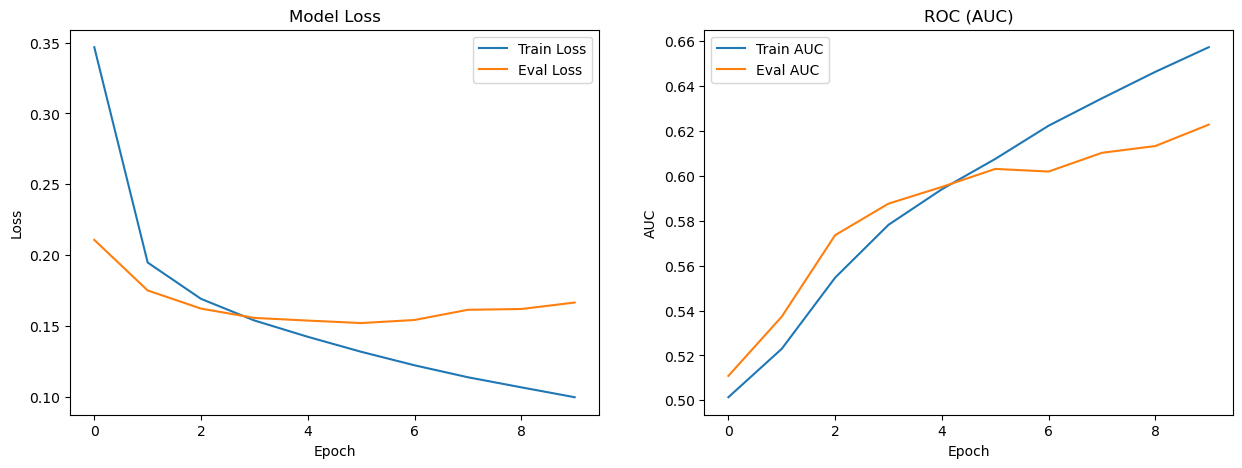

                        precision    recall  f1-score   support

               related       0.90      0.90      0.90      4018
               request       0.79      0.62      0.69       911
                 offer        nan      0.00      0.00        21
           aid_related       0.78      0.70      0.74      2232
          medical_help       0.58      0.27      0.37       438
      medical_products       0.56      0.16      0.25       265
     search_and_rescue        nan      0.00      0.00       152
              security        nan      0.00      0.00        82
              military       0.60      0.47      0.53       166
                 water       0.81      0.62      0.70       345
                  food       0.85      0.74      0.79       607
               shelter       0.74      0.59      0.65       465
              clothing       1.00      0.02      0.05        82
                 money        nan      0.00      0.00       120
        missing_people        nan      

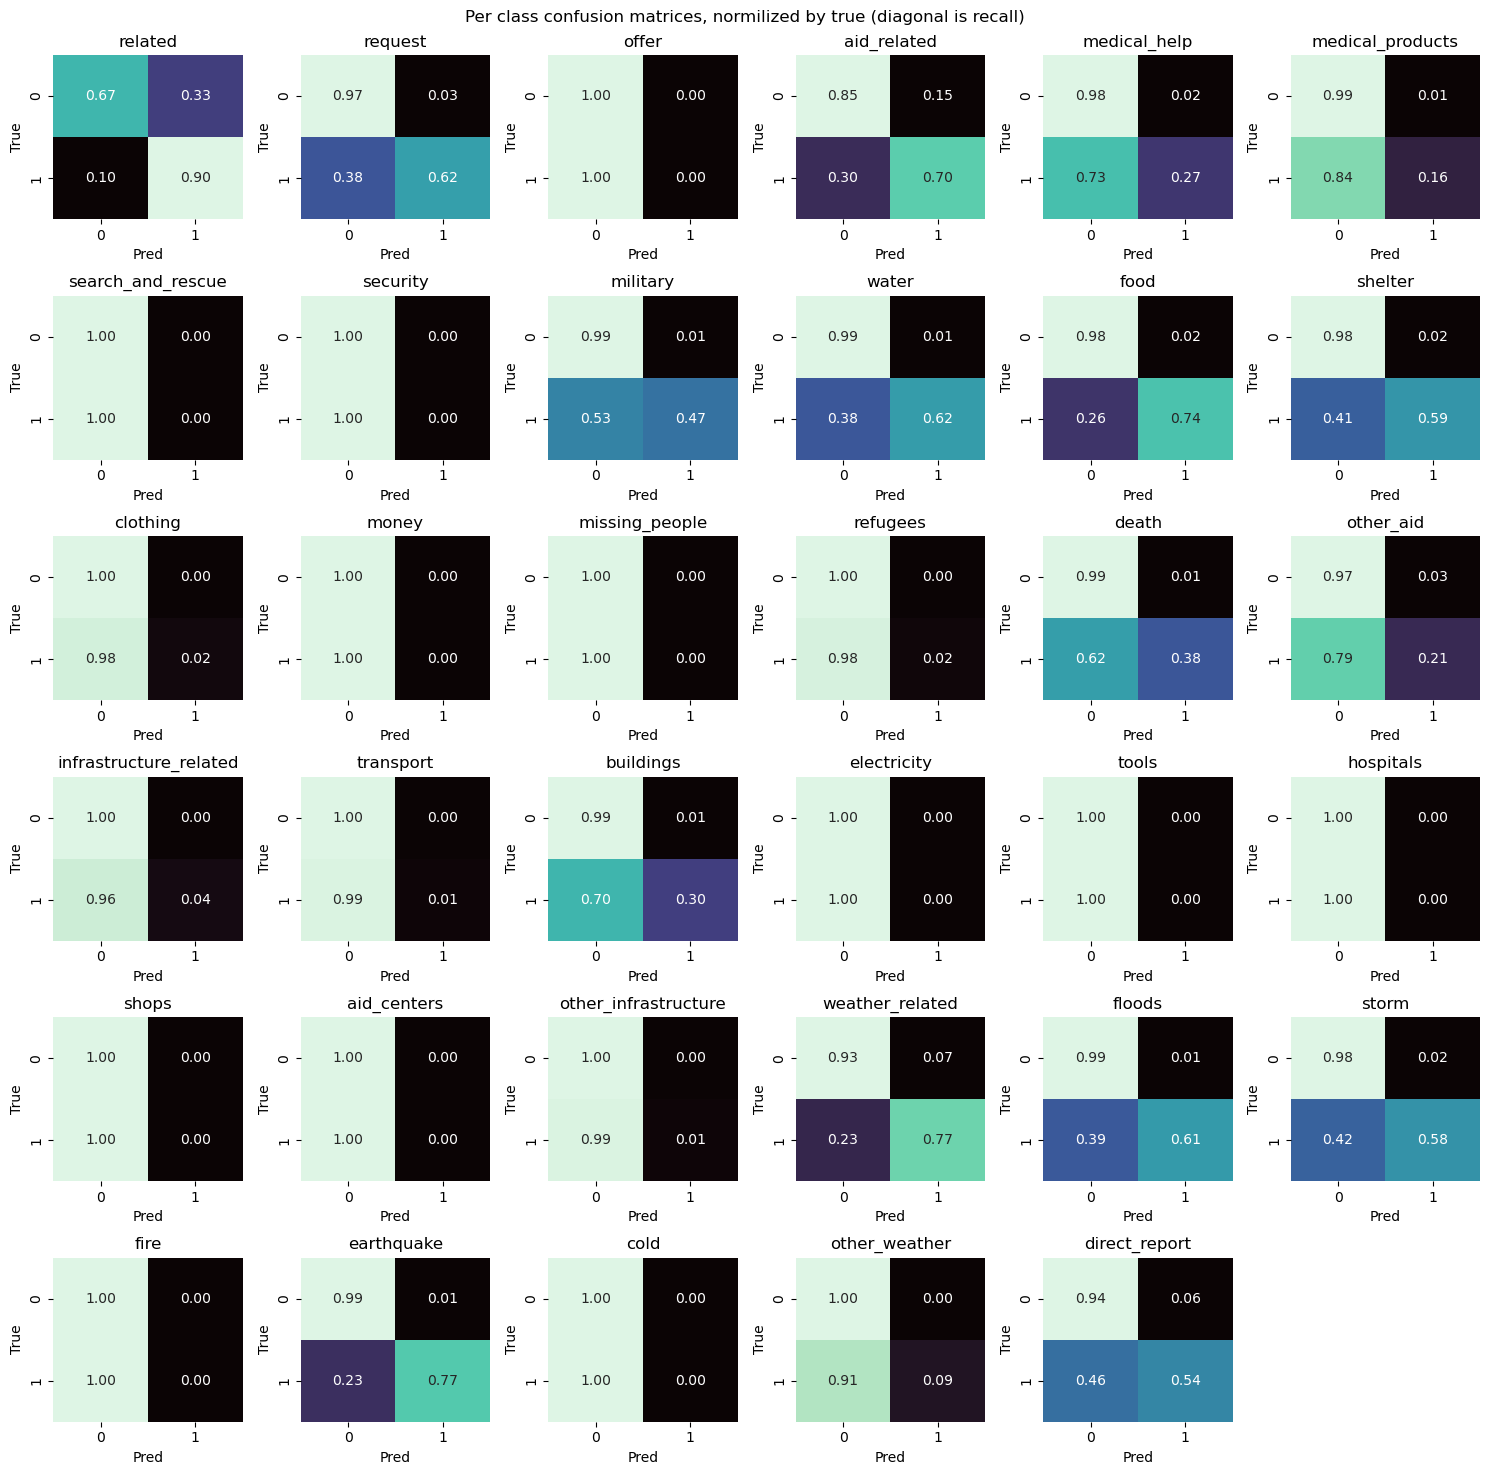

In [8]:
def results(history, epochs, prefix = ""):
    loss = history["loss"]
    val_loss = history["val_loss"]
    auc = history[f'auc{prefix}']
    val_auc =  history[f'val_auc{prefix}']

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(epochs)
        plt.subplot(1, 2, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(auc, val_auc, "AUC", 2, "ROC (AUC)")
    plt.show()
    
def eval_model(test_loader, label_names, model, device):
    model.eval()
    val_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            val_loss += loss.item()

            preds = outputs['preds']
            test_preds.append(preds.cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    test_preds = (np.vstack(test_preds) > 0.5).astype(np.int32)
    test_labels = np.vstack(test_labels)
    cr = classification_report(test_labels, test_preds, target_names = label_names, zero_division=np.nan)
    print(cr)
    
    def plot_cms(y_test, preds, label_names):
        plt.figure(figsize=(15,15))
        for i in range(len(label_names)):
            plt.subplot(6,6,i+1)
            plt.title(f"{label_names[i]}")
            cm = confusion_matrix(y_test[:, i], preds[:, i], normalize = "true")
            sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, cmap="mako")
            plt.ylabel("True")
            plt.xlabel("Pred")
        plt.tight_layout()
        plt.suptitle("Per class confusion matrices, normilized by true (diagonal is recall)")
        plt.subplots_adjust(top=0.95)
        plt.show()
    plot_cms(test_labels, test_preds, label_names)

results(history, EPOCHS,  "")
eval_model(test_loader, label_names, model, "cuda")